In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, GlobalMaxPooling1D
from tqdm import tqdm
import time

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
# # 한글 폰트 적용 코드
# def fix_font():
#     # From https://HC.Dle.pw, By Jinseo Kim
#     # v1.0.0
#     import os
#     import matplotlib as mpl
#     import matplotlib.pyplot as plt
#     os.system("apt-get install -y fonts-nanum")
#     os.system("fc-cache -fv")
#     mpl.font_manager._rebuild()
#     findfont = mpl.font_manager.fontManager.findfont
#     mpl.font_manager.findfont = findfont
#     mpl.backends.backend_agg.findfont = findfont
#     plt.rcParams['font.family'] = "NanumBarunGothic"
#     plt.rcParams['axes.unicode_minus'] = False
           
# fix_font()

In [2]:
data = pd.read_csv('./naver_story_002.csv')
data

,Unnamed: 0,expert_score,netizen_score,title,e_title,running_time,story,making_note,box_office,grade
0,10001,8.38,9.63,시네마 천국,"Cinema Paradiso , 1988",124.0,어린 시절 영화가 세상의 전부였던 소년 토토는 학교 수업을 마치면 마을 광장에 있는...,NaN,-1,전체 관람가
1,10002,8.75,9.39,빽 투 더 퓨쳐,"Back To The Future , 1985",120.0,힐 밸리(Hill Valley)에 사는 주인공 마티 맥플라이(Marty McFly:...,NaN,-1,12세 관람가
2,10003,7.50,9.65,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",107.0,브라운 박사(Dr. Emmett 'Doc' L. Brown: 코리스토퍼 로이드 분)...,NaN,-1,12세 관람가
3,10004,-1.00,-1.00,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",117.0,1955년에 남겨진 마티는 박사가 1885년으로 갔음을 알게 된다. 그의 흔적을 찾...,NaN,-1,전체 관람가
4,10010,-1.00,-1.00,슈퍼맨 3,"Superman III , 1983",100.0,대그룹의 총수인 로스 웹스터(Ross Webster: 로버트 본 분)와 여동생 베라...,NaN,-1,전체 관람가
...,...,...,...,...,...,...,...,...,...,...
31738,190855,-1.00,-1.00,레이싱 인 더 레인,"The Art of Racing in the Rain , 2019",108.0,"경주용 자동차 스피드 레이서인 데니가 사랑하는 여인을 만나 딸을 낳고, 가정을 이루...",NaN,-1,전체 관람가
31739,190856,-1.00,-1.00,벌레스크,"Az budou kravy litat , Burlesque , 2019",83.0,옷을 벗으라고? 내가 어떻게?\n베티는 과체중의 초등학교 선생님이다. 친구를 따라 ...,NaN,-1,15세 관람가
31740,190977,6.00,8.00,차일드 인 타임,"The Child in Time , 2017",93.0,유명한 동화 작가 ‘스티븐’에게 세상에서 가장 소중한 딸 ‘케이트’가 실종되는 사건...,ISSUE POINT #1\n더욱 깊어진 눈빛과 섬세한 감정 연기로 돌아온 베네딕트...,-1,15세 관람가
31741,190978,-1.00,-1.00,어웨이크너: 히어로의 탄생,"The Awakener , 2018",106.0,"부패 정치인 처단을 위한, 맞춤형 히어로의 탄생!\n의문의 사고로 사랑하는 딸 ‘알...",NaN,-1,15세 관람가


In [3]:
subset_df = data[['title', 'grade', 'story']]
# subset_df.head(20)

In [ ]:
# # 레이블 분포 확인
# subset_df['grade'].value_counts().plot(kind='bar')

In [ ]:
# subset_df['grade'].unique()

In [4]:
subset_df.drop_duplicates(subset = ['story'], inplace=True) # 중복 제거
subset_df['story'] = subset_df['story'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
subset_df['story'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
subset_df = subset_df.dropna(how='any') # Null 값 제거

In [5]:
# 맞춰야하는 grade를 y로 두고 labelencoding 하기
X = subset_df.drop(['grade'], axis=1)
y = subset_df['grade']
le = LabelEncoder()
y = le.fit_transform(y)

In [6]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
!pip install konlpy

from konlpy.tag import Mecab
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh

In [8]:
# Mecab을 이용한 토큰화
from konlpy.tag import Okt, Mecab

# mecab = Mecab()
okt = Okt()

# 불용어 제거
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [9]:
# train data mecab을 통한 형태소 분석

train_X = []

for sentence in tqdm(X_train['story']):
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    train_X.append(stopwords_removed_sentence)

100%|█| 25253/25253 [09:51<00:00, 42.66


In [10]:
# test data mecab을 통한 형태소 분석

test_X = []

for sentence in tqdm(X_test['story']):
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    test_X.append(stopwords_removed_sentence)

100%|█| 6314/6314 [02:25<00:00, 43.43it


In [ ]:
# X_train = train_X
# X_test = test_X

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X_train)

In [ ]:
# print(tokenizer.word_index)

In [ ]:
# threshold = 3
# total_cnt = len(tokenizer.word_index) # 단어의 수
# rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
# total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
# rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
# for key, value in tokenizer.word_counts.items():
#     total_freq = total_freq + value

#     # 단어의 등장 빈도수가 threshold보다 작으면
#     if(value < threshold):
#         rare_cnt = rare_cnt + 1
#         rare_freq = rare_freq + value

# print('단어 집합(vocabulary)의 크기 :',total_cnt)
# print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
# print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
# print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [11]:
X_train = train_X
X_test = test_X

# 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = len(tokenizer.word_index) + 1
# print('단어 집합의 크기 :',vocab_size)

# text sequence to int sequence
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [13]:
# fasttext word embedding
import gensim
from gensim.models.fasttext import FastText

embeddings_dictionary = dict()
fasttext = open('./wiki.ko.vec', encoding='utf8')

for line in fasttext:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
    
fasttext.close()

embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
# # GloVe word embedding
# embeddings_dictionary = dict()
# glove = open('./glove.6B.100d.txt', encoding='utf8')

# for line in glove:
#     records = line.split()
#     word = records[0]
#     vector_dimensions = np.asarray(records[1:], dtype='float32')
#     embeddings_dictionary[word] = vector_dimensions
    
# glove.close()

# embedding_matrix = np.zeros((vocab_size, 100))
# for word, index in tokenizer.word_index.items():
#     embedding_vector = embeddings_dictionary.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[index] = embedding_vector

In [ ]:
# # 토큰화
# tokenizer = Tokenizer(num_words=10000)
# tokenizer.fit_on_texts(X_train)

# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)

# vocab_size = len(tokenizer.word_index) + 1

In [14]:
X_test = pad_sequences(X_test)
X_train = pad_sequences(X_train)

In [15]:
# build the neural network model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, trainable=False))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2022-08-03 19:00:42.169529: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         10174200  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 10,291,964
Trainable params: 117,764
Non-trainable params: 10,174,200
_________________________________________________________________


In [16]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
158/158 [==============================] - 12041s 76s/step - loss: 1.2808 - accuracy: 0.4009 - val_loss: 1.2460 - val_accuracy: 0.4266
Epoch 2/10
158/158 [==============================] - 11193s 71s/step - loss: 1.2496 - accuracy: 0.4208 - val_loss: 1.2314 - val_accuracy: 0.4296
Epoch 3/10
158/158 [==============================] - 11092s 70s/step - loss: 1.2283 - accuracy: 0.4337 - val_loss: 1.2129 - val_accuracy: 0.4387
Epoch 4/10
158/158 [==============================] - 11279s 71s/step - loss: 1.2281 - accuracy: 0.4363 - val_loss: 1.2201 - val_accuracy: 0.4300
Epoch 5/10
158/158 [==============================] - 12293s 78s/step - loss: 1.2147 - accuracy: 0.4433 - val_loss: 1.2077 - val_accuracy: 0.4397
Epoch 6/10
158/158 [==============================] - 12480s 79s/step - loss: 1.2073 - accuracy: 0.4450 - val_loss: 1.1946 - val_accuracy: 0.4457
Epoch 7/10
158/158 [==============================] - 12975s 82s/step - loss: 1.2028 - accuracy: 0.4469 - val_loss: 1.2021 -

In [17]:
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('loss: ', loss)
print('accuracy: ', acc)

198/198 [==============================] - 108s 544ms/step - loss: 1.1923 - accuracy: 0.4558
loss:  1.1922810077667236
accuracy:  0.4558124840259552


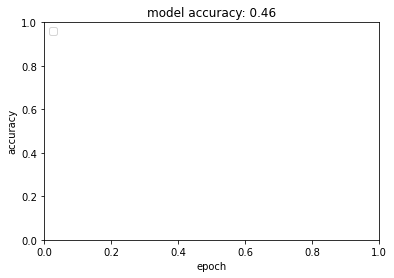

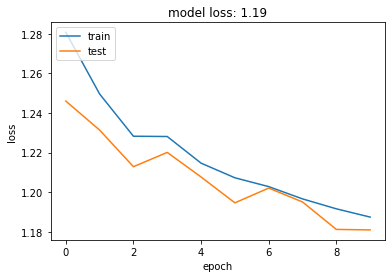

In [19]:
# plt.plot(hist.history['acc'])
# plt.plot(hist.history['val_acc'])
plt.title('model accuracy: {:.2f}'.format(acc))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss: {:.2f}'.format(loss))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
# save the model
model.save('movie_description_classifier_fasttext.h5')

# save the tokenizer for use in other clients
pickle.dump(tokenizer, open('tokenizer3.pkl', 'wb'))